#**CatBoost 개요**

catboost는 2017년 러시아의 yandex에서 제안된 알고리즘이다.

기존 gradient boosting이 숫자형 자료(numerical feature)를 쉽게 다루지만 범주형 자료(categorical feature)는 잘 다루지 못했다.

여기서 숫자형 자료는 숫자로 표현되는 자료로 대소를 비교할 수 있지만, 범주형 자료는 주로 성별(남, 여), 혈액형(A, B, O, AB)와 같은 자료로 대소를 비교할 수 없는 문제점이 있다.

그래서 기존의 gradient boosting 알고리즘을 사용할 때 데이터 셋에 존재하는 범주형 자료를 원-핫인코딩과 같은 별도의 작업 이후에 알고리즘을 적용하여 학습을 했었다.

그러나 catboost는 범주형 자료를 훈련(training) 과정에서 이를 수행하여 학습 소요 시간에 이점이 존재한다. 그리고 일반적인 알고리즘과 다르게 리프 값을 선택한 다음 트리 구조를 선택하는 방식을 사용하여 과적합을 줄일 수 있다.

이번에 catboost를 활용하는 예제를 catboost에서 제공하는 tutorial을 참고하였으며, catboost에서 제공하는 다양한 메소드, 학습 기법들을 사용할 수 있다.

참고자료 및 사이트:

catboost 공식 홈페이지: [https://catboost.ai/](https://catboost.ai/)


catboost 관련 논문: [https://catboost.ai/docs/concepts/educational-materials-papers.html](https://catboost.ai/docs/concepts/educational-materials-papers.html)

catboost tutorial colab 파일 : [https://colab.research.google.com/github/catboost/tutorials/blob/master/python_tutorial.ipynb](https://colab.research.google.com/github/catboost/tutorials/blob/master/python_tutorial.ipynb)



#1. catboost 설치

In [3]:
!pip3 install catboost

     |████████████████████████████████| 64.8MB 58kB/s 


#2. google drive 사용 설정

In [16]:
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [17]:
%cd "/content/gdrive/My Drive/4th_2020/kisti_kaggle"

/content/gdrive/My Drive/4th_2020/kisti_kaggle


#3. csv 파일 읽기 및 데이터 분리

##3.1. csv 파일 읽기

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn scheme 설정
plt.style.use('seaborn')
# 그래프의 폰트 설정
sns.set(font_scale=2.5) 
# 데이터셋의 missing data 쉽게 보여주기
import missingno as msno

#ignore warnings
#import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline

In [21]:
WORK_DIR = '.'
df_train = pd.read_csv(WORK_DIR + '/datasets/train.csv')
df_test = pd.read_csv(WORK_DIR + '/datasets/test.csv')

df_train.head(10)

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S
5            6         0       3  ...   8.4583   NaN         Q
6            7         0       1  ...  51.8625   E46         S
7            8         0       3  ...  21.0750   NaN         S
8            9         1       3  ...  11.1333   NaN         S
9           10         1       2  ...  30.0708   NaN         C

[10 rows x 12 columns]

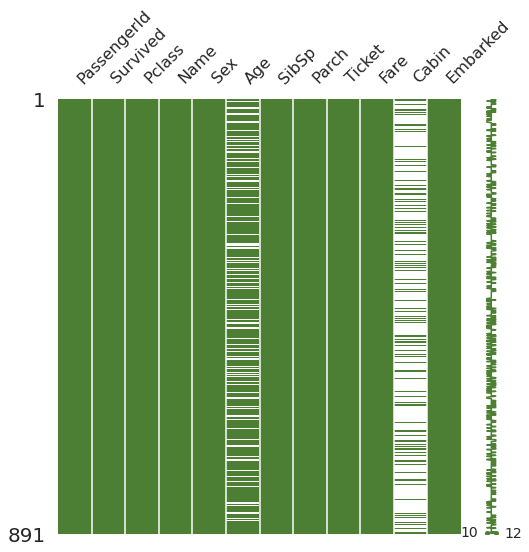

In [22]:
#가져온 데이터 상태 확인,
import missingno as msno
msno.matrix(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.3, 0.5, 0.2))

##3.2. null값 처리

In [23]:
#데이터가 빈 것을 그래프로 확인한 후, 누락된 데이터 갯수 확인
null_value_stats = df_train.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

**Age, Cabin** 그리고 **Embarked**에 누락된 값이 확인되었고, 이를 쉽게 구분하기 위해 -999를 채운다.

In [0]:
df_train.fillna(-999, inplace=True)
df_test.fillna(-999, inplace=True)

데이터셋에서 우리가 분류하고자 하는 Feature인 **Survived**를 분리한다.

##3.3. Feature 분리

In [0]:
#X가 Survived와 연관된 변수가 되고
X = df_train.drop('Survived', axis=1)
#y는 Survived정보가 된다.
y = df_train.Survived

X에 존재하는 feature들의 타입을 확인한다. 일부 범주형 데이터에 있는 문자열들은 catboost의 내부 알고리즘이 처리할 것이다.

In [31]:
print(X.dtypes)
categorical_features_indices = np.where(X.dtypes != np.float)[0]

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


##3.4. 학습, 검증 데이터 분리

In [0]:
from sklearn.model_selection import train_test_split
#train_size가 학습 데이터의 비중이다
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = df_test

# 4. Catboost 사용하기

## 4.1. 모듈 import와 학습 모델 생성

In [0]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

In [0]:
model = CatBoostClassifier(custom_loss=['Accuracy'], 
                           random_seed=42, 
                           logging_level='Silent')

In [43]:
#과정을 확인하고 싶으면 logging_level의 주석을 제거하면 된다.
model.fit(X_train, y_train, 
          cat_features=categorical_features_indices, 
          eval_set=(X_validation, y_validation),
          #logging_level='Verbose',
          plot=True)

Learning rate set to 0.028683


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6739988	test: 0.6742630	best: 0.6742630 (0)	total: 11.8ms	remaining: 11.8s
1:	learn: 0.6589013	test: 0.6592240	best: 0.6592240 (1)	total: 14.6ms	remaining: 7.3s
2:	learn: 0.6421502	test: 0.6426778	best: 0.6426778 (2)	total: 24.9ms	remaining: 8.26s
3:	learn: 0.6297276	test: 0.6302310	best: 0.6302310 (3)	total: 31ms	remaining: 7.72s
4:	learn: 0.6147184	test: 0.6198228	best: 0.6198228 (4)	total: 37.4ms	remaining: 7.43s
5:	learn: 0.6017730	test: 0.6073627	best: 0.6073627 (5)	total: 45ms	remaining: 7.45s
6:	learn: 0.5885309	test: 0.5956000	best: 0.5956000 (6)	total: 52.6ms	remaining: 7.46s
7:	learn: 0.5783200	test: 0.5858523	best: 0.5858523 (7)	total: 60.3ms	remaining: 7.48s
8:	learn: 0.5665895	test: 0.5743842	best: 0.5743842 (8)	total: 67.1ms	remaining: 7.39s
9:	learn: 0.5575381	test: 0.5662283	best: 0.5662283 (9)	total: 82.6ms	remaining: 8.18s
10:	learn: 0.5491045	test: 0.5575176	best: 0.5575176 (10)	total: 100ms	remaining: 9.01s
11:	learn: 0.5423887	test: 0.5505905	best: 0.55

##4.2. 교차검증(Cross-Validation) 

In [45]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [49]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.83±0.02 on step 543


In [50]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.8260381593714928


교차 검증(Cross-Validation)을 마쳤으니 모델을 적용시킨다.

In [52]:
pred = model.predict(X_test)
pred_probs = model.predict_proba(X_test)
#예측 결과
print(pred[:10])
#[0으로 예측한 확률, 1으로 예측한 확률]
print(pred_probs[:10])

[0 0 0 0 1 0 1 0 1 0]
[[0.85473931 0.14526069]
 [0.76313031 0.23686969]
 [0.88972889 0.11027111]
 [0.87876173 0.12123827]
 [0.3611047  0.6388953 ]
 [0.90513381 0.09486619]
 [0.33434185 0.66565815]
 [0.78468564 0.21531436]
 [0.39429048 0.60570952]
 [0.94047549 0.05952451]]


##4.3. 파라미터 사용하기

In [0]:
#Model에 들어갈 변수
params = {
    'iterations':500,
    'learning_rate':0.1,
    'eval_metric': 'Accuracy',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

In [58]:
#params에 기입된 정보로 모델 생성
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool)

print('Simple model validation accuracy: {: .4}'.format(
    accuracy_score(y_validation, model.predict(X_validation))
))
print('')
print('Best model validation accuracy: {: .4}'.format(
    accuracy_score(y_validation, best_model.predict(X_validation))
))

Simple model validation accuracy:  0.8027

Best model validation accuracy:  0.8251


## 4.4. early stopping 사용하기

아까 기존 데이터 셋에서 학습 데이터와 검증 데이터를 나눴다. 검증 데이터 셋이 있을 때 시간 절약과 품질 향상을 위한 early stopping기법을 사용하는 것이 좋다.

In [60]:
%%time
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

CPU times: user 5.2 s, sys: 693 ms, total: 5.9 s
Wall time: 3.65 s


In [68]:
%%time
earlystop_params = params.copy()
earlystop_params.update({
    'od_type': 'Iter',
    'od_wait': 40
})
earlystop_model = CatBoostClassifier(**earlystop_params)
earlystop_model.fit(train_pool, eval_set=validate_pool)

CPU times: user 768 ms, sys: 89.3 ms, total: 857 ms
Wall time: 620 ms


In [69]:
%%time
print('Simple model tree count: {}'.format(model.tree_count_))
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, model.predict(X_validation))
))

Simple model tree count: 500
Simple model validation accuracy: 0.8027
CPU times: user 7.8 ms, sys: 0 ns, total: 7.8 ms
Wall time: 11.8 ms


In [70]:
%%time
print('Early-stopped model tree count: {}'.format(earlystop_model.tree_count_))
print('Early-stopped model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, earlystop_model.predict(X_validation))
))

Early-stopped model tree count: 82
Early-stopped model validation accuracy: 0.8072
CPU times: user 5.27 ms, sys: 1.04 ms, total: 6.32 ms
Wall time: 9.25 ms


## 4.5. Baseline 사용하기

기존에 훈련했던 결과를 Baseline으로 만들어 훈련시킬 수 있다.

In [71]:
current_params = params.copy()
current_params.update({
    'iterations': 10
})
model = CatBoostClassifier(**current_params).fit(X_train, y_train, categorical_features_indices)
# Get baseline (only with prediction_type='RawFormulaVal')
baseline = model.predict(X_train, prediction_type='RawFormulaVal')
# Fit new model
model.fit(X_train, y_train, categorical_features_indices, baseline=baseline)

In [72]:
print('Early-stopped model tree count: {}'.format(model.tree_count_))
print('Early-stopped model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, model.predict(X_validation))
))

Early-stopped model tree count: 10
Early-stopped model validation accuracy: 0.7982


## 4.6. 스냅샷 사용하기

catboost는 스냅샷 기능을 제공하여 중간에 장애나 오류로 인해 훈련이 중단된 경우 중단된 지점부터 다시 시작할 수 있다.

In [73]:
params_with_snapshot = params.copy()
params_with_snapshot.update({
    'iterations': 5,
    'learning_rate': 0.5,
    'logging_level': 'Verbose'
})
model = CatBoostClassifier(**params_with_snapshot).fit(train_pool, eval_set=validate_pool, save_snapshot=True)
params_with_snapshot.update({
    'iterations': 10,
    'learning_rate': 0.1,
})
model = CatBoostClassifier(**params_with_snapshot).fit(train_pool, eval_set=validate_pool, save_snapshot=True)

0:	learn: 0.8053892	test: 0.7937220	best: 0.7937220 (0)	total: 2.85ms	remaining: 11.4ms
1:	learn: 0.8008982	test: 0.7982063	best: 0.7982063 (1)	total: 4.82ms	remaining: 7.22ms
2:	learn: 0.8008982	test: 0.7937220	best: 0.7982063 (1)	total: 7.31ms	remaining: 4.88ms
3:	learn: 0.8113772	test: 0.7892377	best: 0.7982063 (1)	total: 10.4ms	remaining: 2.6ms
4:	learn: 0.8173653	test: 0.8026906	best: 0.8026906 (4)	total: 13ms	remaining: 0us

bestTest = 0.802690583
bestIteration = 4

5:	learn: 0.8173653	test: 0.8026906	best: 0.8026906 (4)	total: 15.8ms	remaining: 11.2ms
6:	learn: 0.8248503	test: 0.8026906	best: 0.8026906 (4)	total: 17.7ms	remaining: 7.05ms
7:	learn: 0.8233533	test: 0.8026906	best: 0.8026906 (4)	total: 20.1ms	remaining: 4.74ms
8:	learn: 0.8233533	test: 0.8026906	best: 0.8026906 (4)	total: 21.1ms	remaining: 2.03ms
9:	learn: 0.8233533	test: 0.8026906	best: 0.8026906 (4)	total: 23.3ms	remaining: 0us

bestTest = 0.802690583
bestIteration = 4



##4.7. 단계별 예측(staged predict)

catboost는 staged_predict이라는 메소드를 통해 주어진 트리 범위 내에서 반복적으로 예측 값을 얻을 수 있게 해준다.

In [83]:
classifier_params = {
    'iterations' : 10,
    'random_seed' : 42,
    'logging_level': 'Silent'
}
model = CatBoostClassifier(**classifier_params).fit(train_pool)
ntree_start, ntree_end, eval_period = 3, 9, 2
predictions_iterator = model.staged_predict(validate_pool, 'Probability', ntree_start, ntree_end, eval_period)
for preds, tree_count in zip(predictions_iterator, range(ntree_start, ntree_end, eval_period)):
  print('First class probabilities using the first {} trees: {}'.format(tree_count, preds[:5, 1]))

First class probabilities using the first 3 trees: [0.53597869 0.41039128 0.42057479 0.64281031 0.46576685]
First class probabilities using the first 5 trees: [0.63722688 0.42492029 0.46209302 0.70926021 0.44280772]
First class probabilities using the first 7 trees: [0.66964764 0.42409144 0.46124982 0.76101033 0.47205986]


##4.8. Feature 중요도 확인

catboost 모델은 Feature의 중요도를 확인하는 함수로 get_feature_importance함수를 가지고 있다.

In [84]:
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent').fit(train_pool)
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

Sex: 59.004092014268586
Pclass: 16.340887169747035
Ticket: 6.028107169932204
Cabin: 3.8347242202560192
Fare: 3.712969667934384
Age: 3.484451204182482
Parch: 3.378089740355865
Embarked: 2.3139994072899555
SibSp: 1.9026794060334504
PassengerId: 0.0
Name: 0.0


생존자와 사망자를 분류하는데 가장 중요한 Feature는 성별인 것을 확인할 수 있다.
그 다음은 Pclass이다. 이는 그래프로 확인할 수 있다.

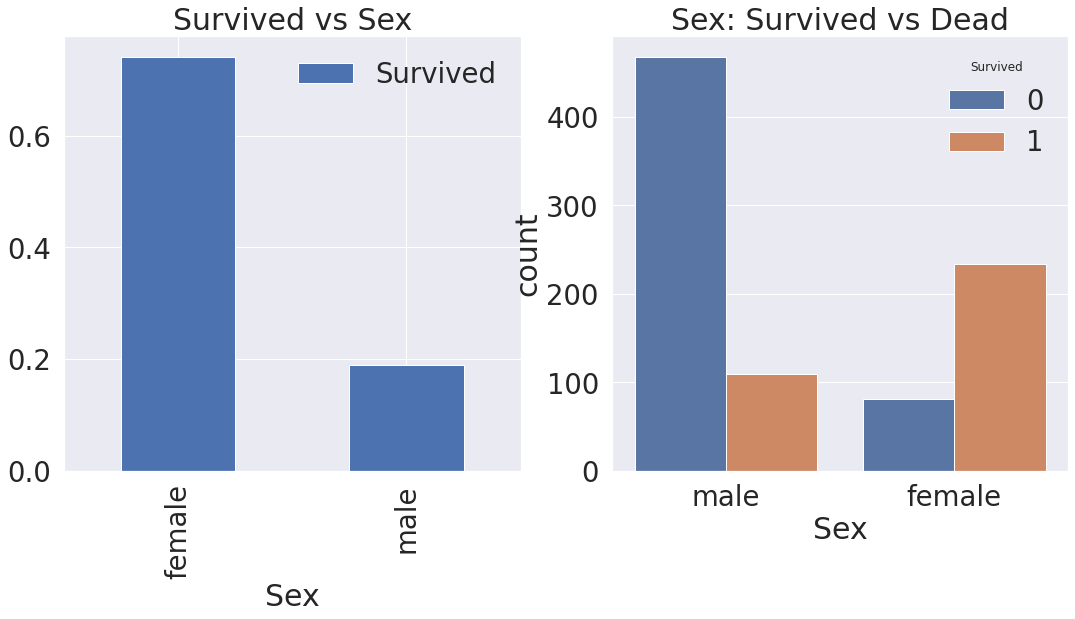

In [85]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train[['Sex', 'Survived']].groupby(['Sex'], 
                          as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

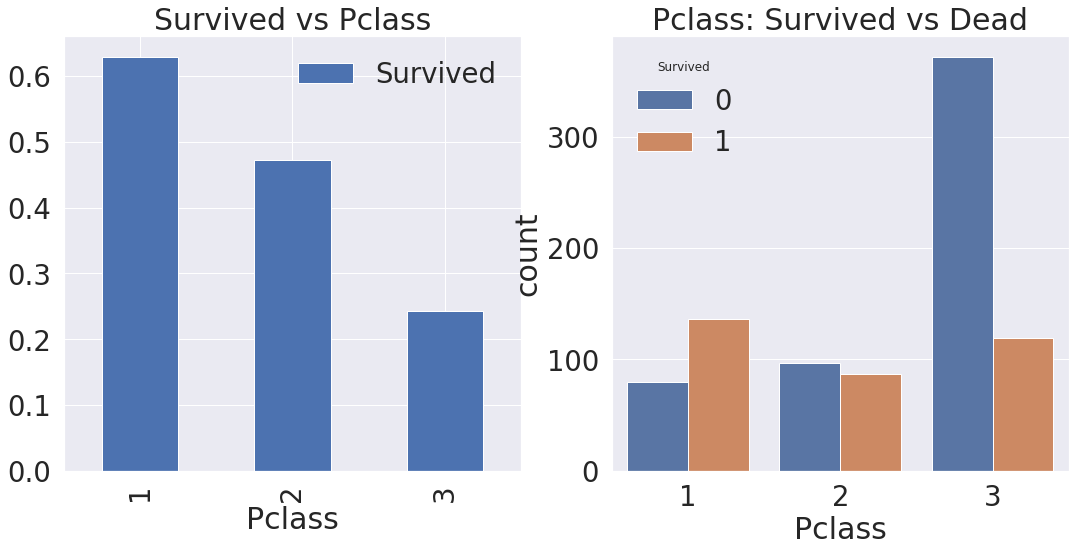

In [86]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train[['Pclass', 'Survived']].groupby(['Pclass'], 
                          as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Pclass')
sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead')
plt.show()

## 4.9. 모델 저장하기

In [0]:
#만든 모델을 저장, 불러오기 할 수 있다.
model = CatBoostClassifier(iterations=10, random_seed=42, logging_level='Silent').fit(train_pool)
model.save_model('catboost_model.dump')
model = CatBoostClassifier()
model.load_model('catboost_model.dump');

#결과 제출하기

학습 결과를 파일로 만들어서 제출하는 과정

In [101]:
params = {
    'iterations':500,
    'learning_rate':0.1,
    'eval_metric': 'Accuracy',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
model = CatBoostClassifier(**params)
model.fit(X, y, cat_features=categorical_features_indices)

In [0]:
import pandas as pd
sub = pd.DataFrame()
sub['PassengerID'] = X_test['PassengerId']
sub['Survived'] = model.predict(X_test)
sub.to_csv('submission.csv', index=False)